<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/Call_GCS_Bucket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Saving data with gsutil

- Use the [Cloud Resource Manager](https://cloud.google.com/resource-manager) to create a project if you do not already have one.
- [Enable billing](https://support.google.com/cloud/answer/6293499#enable-billing) for the project.
- See [Google Cloud Storage (GCS) Documentation](https://cloud.google.com/storage/) for more info.


In [1]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'big-passage-402400'
!gcloud config set project {project_id}


Updated property [core/project].


In [2]:
# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  13112      0 --:--:-- --:--:-- --:--:-- 13163
OK
19 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 5,558 kB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../gcsfuse_1.2.0_amd64.deb ...
Unpacking gcsfuse (1.2.0) ...
Setting up 

In [3]:
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "datahub_bucket"  # or a location like "my-bucket/path/to/mount"
local_path = f"001_{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"time":"01/11/2023 10:30:18.693813","severity":"INFO","msg":"Start gcsfuse/1.2.0 (Go version go1.21.0) for app \"\" using mount point: /content/001_datahub_bucket\n"}


In [4]:
# Then you can access it like a local path.
!ls -lh {local_path}

total 0
drwxr-xr-x 1 root root 0 Nov  1 22:30 Island_Original
drwxr-xr-x 1 root root 0 Nov  1 22:30 subset_data


In [ ]:
!pip install rasterio scikit-image tensorflow keras gdown

In [9]:
import os
import glob
import gdown
import zipfile
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import rasterio
import rasterio.plot
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import load_model
from keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.util import random_noise
from scipy import ndimage
from scipy.ndimage import label as nd_label
from scipy.ndimage import generic_filter
from scipy.stats import mode

In [6]:
path = '/content/001_datahub_bucket'

In [7]:
print(path)

/content/001_datahub_bucket


In [11]:
!mkdir -p {path}/data

In [40]:
!mkdir -p {path}/data/images
!mkdir -p {path}/data/labels


In [44]:
# !mkdir -p /content/data/test
!mkdir -p /content/data/test/images
!mkdir -p /content/data/test/labels

In [46]:
import shutil

source_path = "/content/001_datahub_bucket/Island_Original/Island_Images/Lanai_2000_elevation.tif"
destination_path = "/content/data/test/images/Lanai_2000_elevation.tif"
shutil.copy(source_path, destination_path)

lable_path = '/content/001_datahub_bucket/Island_Original/Island_Labels/lanai_2005_ccap.img'
dest_lable_path = '/content/data/test/labels/lanai_2005_ccap.img'
shutil.copy(lable_path, dest_lable_path)

'/content/data/test/labels/lanai_2005_ccap.img'

In [ ]:
from matplotlib import pyplot
from rasterio.plot import show
src = rasterio.open("/content/001_datahub_bucket/Island_Original/Island_Images/Niihau_2000_elevation.tif")
pyplot.imshow(src.read(7), cmap='gist_earth')
pyplot.show()

In [ ]:
src = rasterio.open("/content/001_datahub_bucket/Island_Original/Island_Images/Oahu_2000_elevation.tif")
pyplot.imshow(src.read(7), cmap='gist_earth_r')
pyplot.show()

In [37]:
from rasterio import windows

In [47]:
clip_width = 256  # Set your desired width
clip_height = 256  # Set your desired height

In [49]:
!mkdir -p /content/data/output

In [48]:
input_directory = "/content/data/test/images"
output_directory = "/content/data/output"

In [50]:
for filename in os.listdir(input_directory):
    if filename.endswith(".tif"):  # Check if the file is a TIFF image
        with rasterio.open(os.path.join(input_directory, filename)) as src:
            # Determine the number of rows and columns in the image
            num_rows, num_cols = src.shape

            # Loop through the image using a sliding window
            for i in range(0, num_rows, clip_height):
                for j in range(0, num_cols, clip_width):
                    window = windows.Window(j, i, clip_width, clip_height)
                    clipped_image = src.read(window=window)
                    # Define the output filename based on the window coordinates
                    output_filename = f"clipped_{i}_{j}_{filename}"
                    output_path = os.path.join(output_directory, output_filename)
                    with rasterio.open(output_path, 'w', **src.profile) as dst:
                        dst.write(clipped_image)

In [ ]:

folder_path = "/content/data/test/labels"

# List the contents of the folder
folder_contents = os.listdir(folder_path)

for item in folder_contents:
    item_path = os.path.join(folder_path, item)
    # Check if the item is a file
    if os.path.isfile(item_path):
        # Get the size in bytes
        size = os.path.getsize(item_path)

        # Initialize shape as None (for non-image files)
        shape = None

        # You can add logic here to determine the shape for image files, for example
        if item.endswith(".jpg") or item.endswith(".png"):
            # Import a library like Pillow (PIL) to get the image dimensions
            from PIL import Image
            with Image.open(item_path) as img:
                shape = img.size

        print(f"Name: {item}, Size (bytes): {size}, Shape: {shape}")
    else:
        print(f"Name: {item} (Directory)")

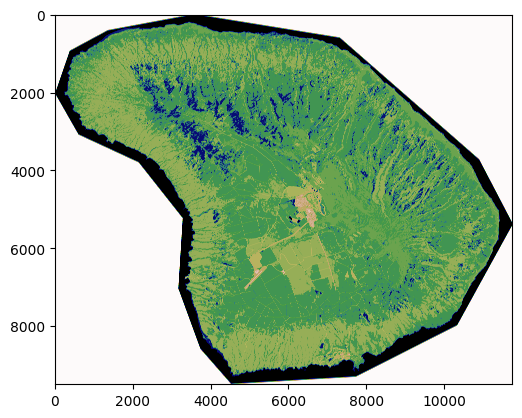

In [65]:
src = rasterio.open("/content/data/test/labels/lanai_2005_ccap.img")
pyplot.imshow(src.read(1), cmap='gist_earth_r')
pyplot.show()